In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings


warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
# Считаем данные
df = pd.read_csv(r'data.csv')

In [3]:
df.head()

,name,quantity,price,day,bread,hotcake,milk_or_sour_milk,cheese_cottage_cheese,others,week_day_0,week_day_1,week_day_2,week_day_3,week_day_4
0,"Ацидофилин 2,7% 200г.ВМК БЗМЖ",4.0,2.46,2,0,0,1,0,0,1,0,0,0,0
1,Батон ГОРЧИЧНЫЙ 300 г. Хлебозавод №1 +,21.0,3.88,2,1,0,0,0,0,1,0,0,0,0
2,Батон Луковый 300г.Орион,2.0,5.96,2,1,0,0,0,0,1,0,0,0,0
3,Батон НАРЕЗНОЙ 400 г. Хлебозавод №1 +,41.0,4.70,2,1,0,0,0,0,1,0,0,0,0
4,Батон Нарезной 400г.Переславский х-д.,5.0,7.70,2,1,0,0,0,0,1,0,0,0,0


In [4]:
# Разобьем выборку на обучающую и тестовую
# Мы делаем это вручную, так как в датафрейме используется день недели как признак
# (одна неделя идет в тестовую выборку, остальное - в обучающую)
# Здесь же удаляем ненужные колонки
train_df = df.query('day < 23').drop(['day', 'name'], axis=1)
test_df = df.query('day >= 23').drop(['day', 'name'], axis=1)

In [5]:
# Отделим целевую переменную
X_train, y_train = train_df.drop('quantity', axis=1), train_df.quantity
X_test, y_test = test_df.drop('quantity', axis=1), test_df.quantity

In [6]:
# Теперь мы можем перейти к обучению моделей

In [7]:
# Импортируем необходимые инструменты
# Также часть инстументов будет импортироваться далее
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [8]:
# Первой мы обучим линейную регрессию с разными её вариациями

In [9]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

In [10]:
# Обучение обычной линейной регрессии
reg = LinearRegression().fit(X_train, y_train)

In [11]:
# Метрики качества модели
print('mse:', mse(y_test, reg.predict(X_test)))
print('mae:', mae(y_test, reg.predict(X_test)))

mse: 21.91779155646977
mae: 2.6781852582607693


In [12]:
# Посмотрим, улучшится ли результат, если масштабировать признаки
sc = StandardScaler()
X_train_scaled = pd.DataFrame(sc.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(sc.transform(X_test), columns=X_test.columns, index=X_test.index)

In [13]:
reg2 = LinearRegression().fit(X_train_scaled, y_train)

In [14]:
print('mse:', mse(y_test, reg2.predict(X_test_scaled)))
print('mae:', mae(y_test, reg2.predict(X_test_scaled)))

mse: 22.132034816033652
mae: 2.7425151877595053


In [15]:
# Посмотрим, улучшится ли результат, если мы добавим регуляризацию
ridge = GridSearchCV(
    Ridge(),
    param_grid={'alpha': [i for i in range (1, 200)]}
)
ridge.fit(X_train, y_train)
ridge.best_params_

{'alpha': 34}

In [16]:
print('mse:', mse(y_test, ridge.predict(X_test)))
print('mae:', mae(y_test, ridge.predict(X_test)))

mse: 21.868158995924603
mae: 2.671261623395296


In [17]:
# Посмотрим, улучшится ли результат, если мы будем использовать L1 норму (Lasso)
l=[i for i in range (1, 200)]
lasso = GridSearchCV(
    Lasso(),
    param_grid={'alpha': l}
)
lasso.fit(X_train, y_train)
lasso.best_params_

{'alpha': 3}

In [18]:
print('mse:', mse(y_test, lasso.predict(X_test)))
print('mae:', mae(y_test, lasso.predict(X_test)))

mse: 22.56229605365303
mae: 2.694127261776902


In [19]:
# Попробуем совместить L1-норму и L2-норму (используем ElasticNet)
l_1=[i for i in range (1, 50)]
l_2=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
el_net = GridSearchCV(
    ElasticNet(),
    param_grid={'alpha': l_1, 'l1_ratio': l_2}
)
el_net.fit(X_train, y_train)
el_net.best_params_

{'alpha': 1, 'l1_ratio': 0.1}

In [20]:
print('mse:', mse(y_test, el_net.predict(X_test)))
print('mae:', mae(y_test, el_net.predict(X_test)))

mse: 22.421067538909234
mae: 2.7100039005587533


In [21]:
# Также, как было сказано в теоретической части, можно обучать линейную регрессию с помощью градиентного спуска
# Давайте попробуем использовать вручную реализованный градиетный спуск и посмотрим, изменится ли значение ошибки модели

In [22]:
from sklearn.base import BaseEstimator

class Gradient_descent(BaseEstimator):
    def __init__(self, eps=1e-4, max_steps=1000, w0=None, alpha=1e-2):
        """
        eps: разница для нормы изменения весов
        max_steps: максимальное кол-во шагов 
        w0: np.array(d) - начальные веса
        alpha: шаг обучения
        """
        self.eps = eps
        self.max_steps = max_steps
        self.w0 = w0
        self.alpha = alpha
        self.w = None
    
    def fit(self, X, y):
        """
        X: np.array(l, d)
        y: np.array(l)
        ---
        output: self
        """
                
        if self.w0 is None:
            self.w0 = np.zeros(X.shape[1])
        
        self.w = self.w0
        
        for step in range(self.max_steps):
            w_new = self.w - self.alpha * self.calc_gradient(X, y)
            
            if np.linalg.norm(w_new - self.w) < self.eps:
                break
            
            self.w = w_new
        
        return self
    
    def calc_gradient(self, X, y):
        """
        X: np.array(l, d)
        y: np.array(l)
        ---
        output: np.array(d)
        """
        
        return (2/X.shape[0]) * np.dot(X.T, (np.dot(X, self.w) - y))
    
    def predict(self, X):
        """
        X: np.array(l, d)
        ---
        output: np.array(l)
        """
        
        if self.w is None:
            raise Exception('Not trained yet')
        
        return np.dot(X, self.w)


In [23]:
gd = Gradient_descent()
gd.fit(X_train_scaled, y_train)
print('mse:', mse(y_test, gd.predict(X_test_scaled)))
print('mae:', mae(y_test, gd.predict(X_test_scaled)))

mse: 33.107698865297436
mae: 3.4829881370522395


In [24]:
# Теперь обучим kNN

In [25]:
from sklearn.neighbors import KNeighborsRegressor

In [26]:
knn = GridSearchCV(
    KNeighborsRegressor(),
    param_grid={
        'n_neighbors': list(range(2, 30)),
        'weights': ['uniform', 'distance'],
        'p': [1, 2, 3]
    }
)

In [27]:
knn.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                         14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
                                         24, 25, 26, 27, 28, 29],
                         'p': [1, 2, 3], 'weights': ['uniform', 'distance']})

In [28]:
knn.best_params_

{'n_neighbors': 25, 'p': 1, 'weights': 'distance'}

In [29]:
print('mse:', mse(y_test, knn.predict(X_test)))
print('mae:', mae(y_test, knn.predict(X_test)))

mse: 20.283274136864765
mae: 2.292419053467014


In [30]:
knn.predict(X_train)

array([ 4. , 21. ,  4.5, ...,  3. ,  4.5,  7. ])

In [31]:
# Попробуем обучить KNN на масштабированных данных
knn.fit(X_train_scaled, y_train)

GridSearchCV(estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                         14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
                                         24, 25, 26, 27, 28, 29],
                         'p': [1, 2, 3], 'weights': ['uniform', 'distance']})

In [32]:
knn.best_params_

{'n_neighbors': 28, 'p': 3, 'weights': 'distance'}

In [33]:
print('mse:', mse(y_test, knn.predict(X_test_scaled)))
print('mae:', mae(y_test, knn.predict(X_test_scaled)))

mse: 20.299726280616284
mae: 2.30012771888199


In [34]:
# Теперь обучим случайный лес

In [35]:
from sklearn.ensemble import RandomForestRegressor

In [36]:
forest = RandomForestRegressor(min_samples_split=5, max_features=0.3)
forest.fit(X_train, y_train)
print('mse:', mse(y_test, forest.predict(X_test)))
print('mae:', mae(y_test, forest.predict(X_test)))

mse: 17.68097674692905
mae: 2.193616321124681


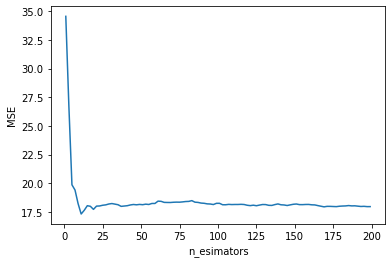

In [37]:
# При построении графика зависимости качества модели от количества дереьев видно, что
# качество в определенный момент выходит на асимптоту
Q = []
for n_est in range(1, 200, 2):
    model = RandomForestRegressor(n_estimators=n_est, min_samples_split=7, max_features=0.3, random_state=13)
    model.fit(X_train, y_train)
    Q.append(mse(y_test, model.predict(X_test)))

plt.plot(range(1, 200, 2), Q)
plt.xlabel('n_esimators')
plt.ylabel('MSE')
plt.show()

In [38]:
# Попробуем обучить случайный лес на масштабированных данных
forest.fit(X_train_scaled, y_train)
print('mse:', mse(y_test, forest.predict(X_test_scaled)))
print('mae:', mae(y_test, forest.predict(X_test_scaled)))

mse: 17.801231013083605
mae: 2.2078948081322474


In [39]:
# Теперь обучим градиентный бустинг

In [40]:
from sklearn.ensemble import GradientBoostingRegressor

In [41]:
gbm = GradientBoostingRegressor()
gbm.fit(X_train, y_train)

GradientBoostingRegressor()

In [42]:
print('mse:', mse(y_test, gbm.predict(X_test)))
print('mae:', mae(y_test, gbm.predict(X_test)))

mse: 16.815422122748263
mae: 2.2071922070011767


In [43]:
# Попробуем подобрать гиперпараметры модели
# Также сравним модели, представленные в разных библиотеках

In [44]:
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [45]:
def trees_num_plot(X_train, y_train, X_test, y_test):
    n_trees = [1, 5, 10, 50, 100, 300, 500, 700, 1000]
    quals_train_lgb = []
    quals_test_lgb = []
    quals_train_cbm = []
    quals_test_cbm = []
    quals_train_gb = []
    quals_test_gb = []

    for n in n_trees:
        lgb = LGBMRegressor(n_estimators=n)
        lgb.fit(X_train, y_train)
        q_train_lgb = mse(y_train, lgb.predict(X_train))
        q_test_lgb = mse(y_test, lgb.predict(X_test))

        cbm = CatBoostRegressor(n_estimators=n, logging_level="Silent")
        cbm.fit(X_train, y_train)
        q_train_cbm = mse(y_train, cbm.predict(X_train))
        q_test_cbm = mse(y_test, cbm.predict(X_test))

        gb = GradientBoostingRegressor(n_estimators=n)
        gb.fit(X_train, y_train)
        q_train_gb = mse(y_train, gb.predict(X_train))
        q_test_gb = mse(y_test, gb.predict(X_test))

        quals_train_lgb.append(q_train_lgb)
        quals_test_lgb.append(q_test_lgb)
        quals_train_cbm.append(q_train_cbm)
        quals_test_cbm.append(q_test_cbm)
        quals_train_gb.append(q_train_gb)
        quals_test_gb.append(q_test_gb)


    plt.figure(figsize=(11.5, 7))
    plt.plot(n_trees, quals_train_lgb, marker='.', label='LightGBM train')
    plt.plot(n_trees, quals_test_lgb, marker='.', label='LightGBM test')
    plt.plot(n_trees, quals_train_cbm, marker='.', label='CatBoost train')
    plt.plot(n_trees, quals_test_cbm, marker='.', label='CatBoost test')
    plt.plot(n_trees, quals_train_gb, marker='.', label='Sklearn train')
    plt.plot(n_trees, quals_test_gb, marker='.', label='Sklearn test')
    plt.xlabel('Number of trees')
    plt.ylabel('MSE')
    plt.legend()

    plt.show()

In [46]:
def trees_depth_plot(X_train, y_train, X_test, y_test):
    depth = list(range(1, 12, 2))
    n_trees = 100
    quals_train_lgb = []
    quals_test_lgb = []
    quals_train_cbm = []
    quals_test_cbm = []
    quals_train_gb = []
    quals_test_gb = []

    for d in depth:
        lgb = LGBMRegressor(n_estimators=n_trees, max_depth=d)
        lgb.fit(X_train, y_train)
        q_train_lgb = mse(y_train, lgb.predict(X_train))
        q_test_lgb = mse(y_test, lgb.predict(X_test))

        cbm = CatBoostRegressor(n_estimators=n_trees, max_depth=d, logging_level="Silent")
        cbm.fit(X_train, y_train)
        q_train_cbm = mse(y_train, cbm.predict(X_train))
        q_test_cbm = mse(y_test, cbm.predict(X_test))

        gb = GradientBoostingRegressor(n_estimators=n_trees, max_depth=d)
        gb.fit(X_train, y_train)
        q_train_gb = mse(y_train, gb.predict(X_train))
        q_test_gb = mse(y_test, gb.predict(X_test))

        quals_train_lgb.append(q_train_lgb)
        quals_test_lgb.append(q_test_lgb)
        quals_train_cbm.append(q_train_cbm)
        quals_test_cbm.append(q_test_cbm)
        quals_train_gb.append(q_train_gb)
        quals_test_gb.append(q_test_gb)


    plt.figure(figsize=(11.5, 7))
    plt.plot(depth, quals_train_lgb, marker='.', label='LightGBM train')
    plt.plot(depth, quals_test_lgb, marker='.', label='LightGBM test')
    plt.plot(depth, quals_train_cbm, marker='.', label='CatBoost train')
    plt.plot(depth, quals_test_cbm, marker='.', label='CatBoost test')
    plt.plot(depth, quals_train_gb, marker='.', label='Sklearn train')
    plt.plot(depth, quals_test_gb, marker='.', label='Sklearn test')
    plt.xlabel('Depth of trees')
    plt.ylabel('MSE')
    plt.legend()

    plt.show()

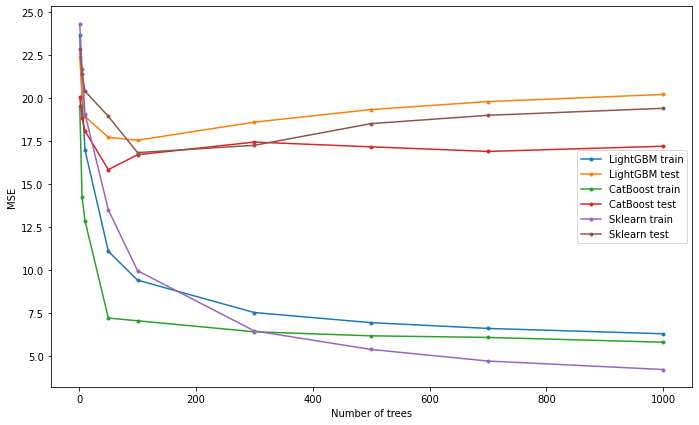

In [47]:
trees_num_plot(X_train, y_train, X_test, y_test)

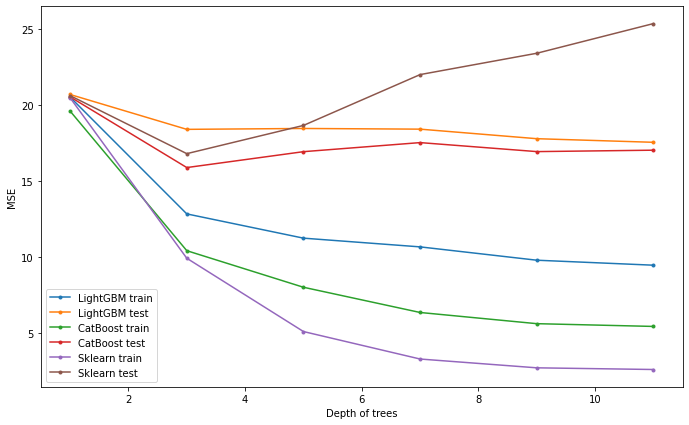

In [48]:
trees_depth_plot(X_train, y_train, X_test, y_test)

In [49]:
# Из графиков видно, что модель, представленная ниже, наилучшая
cb_reg = CatBoostRegressor(logging_level='Silent', n_estimators=100, max_depth=3)
cb_reg.fit(X_train, y_train)
print('mse:', mse(y_test, cb_reg.predict(X_test)))
print('mae:', mae(y_test, cb_reg.predict(X_test)))

mse: 15.907881599713244
mae: 2.20195774294398


In [50]:
# Также можно заметить, что масштабирование практически не изменяет значения ошибок
cb_reg_sc = CatBoostRegressor(logging_level='Silent', n_estimators=100, max_depth=3)
cb_reg_sc.fit(X_train_scaled, y_train)
print('mse:', mse(y_test, cb_reg_sc.predict(X_test_scaled)))
print('mae:', mae(y_test, cb_reg_sc.predict(X_test_scaled)))

mse: 15.854802008501085
mae: 2.2014166657616823


In [51]:
# Последнее, что мы попробуем - блендинг бустинга и случайного леса, блендинг бустинга и kNN

In [52]:
def select_weights(y_true, y_pred_1, y_pred_2):
    metric = []
    grid = np.linspace(0, 1, 1000)
    for w_0 in grid:
        w_1 = 1 - w_0
        y = y_pred_1 * w_0 + y_pred_2 * w_1
        metric.append([mse(y_true, y), mae(y_true, y), w_0, w_1])
    
    return min(metric, key=lambda x: x[0])

In [53]:
select_weights(y_test, forest.predict(X_test), cb_reg.predict(X_test))

[15.669335150035092,
 2.1167794857921525,
 0.12412412412412413,
 0.8758758758758759]

In [54]:
select_weights(y_test, knn.predict(X_test), cb_reg.predict(X_test))

[15.614716100212577,
 2.0816342057209103,
 0.11711711711711711,
 0.8828828828828829]

In [55]:
# Заключение: как можно заметить, лучшей моделью оказался блендинг градиентного бустинга из библиотеки CatBoost и KNN
# Далее мы реализуем графический интерфейс, в котором будем использовать именно эту модель

In [56]:
# Загрузим обученную нами модель в файл
cb_reg.save_model("cb_reg.txt")

In [57]:
with open(r"weights.txt", "w") as file:
    param = select_weights(y_test, knn.predict(X_test), cb_reg.predict(X_test))
    file.write(str(param[2]))
    file.write('\n')
    file.write(str(param[3]))

In [58]:
X_train.to_csv('train_data.csv', index=False)
y_train.to_csv('train_data_targets.csv', index=False)
# df.drop(['day', 'name', 'quantity'], axis=1).to_csv('data_to_test.csv', index=False)